#### Milestone 4 - Decision Tree

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, isnan, count, when, isnull, size, split
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, FloatType, DateType
from pyspark.sql.functions import col, regexp_replace
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
spark = SparkSession.builder.appName('final_project').getOrCreate()

In [0]:
# # Put in your bucket and folder path without the csv file
# BUCKET = 'gs://ds5460-tlee-spring2024/notebooks/jupyter//data/usa/combined_datasets/' 

# data_with_review = spark.read.csv(BUCKET + 'real-final-data.csv',inferSchema=True,header=True)
# data_with_zero_review = spark.read.csv(BUCKET + 'target_column_with_zero_review.csv',inferSchema=True,header=True)

In [0]:
display(dbutils.fs.ls("/mnt"))

path,name,size,modificationTime
dbfs:/mnt/bdbucket1/,bdbucket1/,0,0


In [0]:
data_with_review = spark.read.format("csv").option("header", "true").load("dbfs:/mnt/bdbucket1/real-final-data.csv")
data_with_zero_review = spark.read.format("csv").option("header", "true").load("dbfs:/mnt/bdbucket1/target_column_with_zero_review.csv")

In [0]:
# Double check the data was read in properly
data_with_review.head()

Row(host_total_listings_count='3.0', accommodates='8', num_bath='3.0', bedrooms='4.0', beds='6.0', price='500.0', amenities_count='14', essential_amenities='3', host_is_superhost='t', city='Broward County', room_type='Entire home/apt', full_time_host='f', host_verifications_clean='ep', target='Great')

In [0]:
# Double check the data was read in properly
data_with_zero_review.head()

Row(id='827736378366911479', host_id='475630606', host_since='2022-08-18', host_location='Unknown', host_is_superhost='f', host_listings_count='1.0', host_total_listings_count='3.0', host_has_profile_pic='t', host_identity_verified='t', neighborhood='Fort Lauderdale', latitude='26.09393643124416', longitude='-80.13759087771177', room_type='Entire home/apt', accommodates='2', num_bath='1.0', bedrooms='1.0', beds='1.0', price='222.0', number_of_reviews='0', review_scores_value=None, calculated_host_listings_count='1', city='Broward County', amenities_count='10', neighborhood_city='Fort Lauderdale Broward County', full_time_host='f', host_verifications_clean='p', essential_amenities='3')

In [0]:
# Drop columns that can't be used in the feature pipeline as not applicable to zero reviews
data_with_zero_review = data_with_zero_review.drop('review_scores_value')
data_with_zero_review = data_with_zero_review.drop('number_of_reviews')

In [0]:
# Double check the columns in data_with_review
data_with_review.columns

['host_total_listings_count',
 'accommodates',
 'num_bath',
 'bedrooms',
 'beds',
 'price',
 'amenities_count',
 'essential_amenities',
 'host_is_superhost',
 'city',
 'room_type',
 'full_time_host',
 'host_verifications_clean',
 'target']

### Create the Feature Pipeline

In [0]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType

# Assuming the most appropriate data types based on the feature names:
conversion_map = {
    'host_total_listings_count': IntegerType(),
    'accommodates': IntegerType(),
    'num_bath': DoubleType(),  # Using DoubleType in case there are half-baths represented as decimals
    'bedrooms': IntegerType(),
    'beds': IntegerType(),
    'price': DoubleType(),  # Price could include decimal places for cents
    'amenities_count': IntegerType(),
    'essential_amenities': IntegerType()
}

# Convert string columns to numeric columns
for column, data_type in conversion_map.items():
    data_with_review = data_with_review.withColumn(column, col(column).cast(data_type))
    data_with_zero_review = data_with_zero_review.withColumn(column, col(column).cast(data_type))

In [0]:
# List of string features to be indexed and the features that are already numeric
stringFeatures = ['host_is_superhost', 'city', 'room_type', 'full_time_host', 'host_verifications_clean']

numericFeatures = ['host_total_listings_count', 'accommodates', 
                   'num_bath','bedrooms', 'beds', 'price',
                   'amenities_count', 'essential_amenities']

# Create StringIndexer stages for the stringFeatures - call the numeric version as _indexed
indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed", stringOrderType="alphabetAsc").setHandleInvalid("skip")
            for column in stringFeatures]

# Create a StringIndexer for the target column and naming it as target_label after converting it to numeric
labelIndexer = StringIndexer(inputCol='target', outputCol='target_label').setHandleInvalid("skip")

# Create VectorAssembler stage for the features
assemblerInputs = [column+"_indexed" for column in stringFeatures] + numericFeatures
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Create and run the pipeline with the target indexer added to pipeline
pipeline = Pipeline(stages=indexers + [assembler, labelIndexer])

# Fit the pipeline on the training data - which is all of data that has reviews
pipelineModel = pipeline.fit(data_with_review)

# Alternative code if we wanted to do the train/test split earlier
# trainingDataTransformed = pipelineModel.transform(trainingData)
# testDataTransformed = pipelineModel.transform(testData)

# Apply the pipeline on the data_with_review - trainingDataTransformed seen below will have to go through a train/test split
trainingDataTransformed = pipelineModel.transform(data_with_review)


# To apply the pipeline on the data_with_zero_review, which is missing the target, we need to do the following:
# Extracting the transformation stages from the fitted pipeline model
# Excldue the LabelIndexer from final pipeline stage as we are applying on the prediction dataset
transformationStages = pipelineModel.stages[:-1]

# Manually apply each transformation stage to the data_with_zero_review
transformedData = data_with_zero_review
for stage in transformationStages:
    transformedData = stage.transform(transformedData)

# We now have dataWithZeroReviewTransformed which doesn't have the target_label column to see what is our final model predictions
dataWithZeroReviewTransformed = transformedData

### Check if Feature Pipeline was done properly

In [0]:
trainingDataTransformed.printSchema()

root
 |-- host_total_listings_count: integer (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- num_bath: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- beds: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- amenities_count: integer (nullable = true)
 |-- essential_amenities: integer (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- city: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- full_time_host: string (nullable = true)
 |-- host_verifications_clean: string (nullable = true)
 |-- target: string (nullable = true)
 |-- host_is_superhost_indexed: double (nullable = false)
 |-- city_indexed: double (nullable = false)
 |-- room_type_indexed: double (nullable = false)
 |-- full_time_host_indexed: double (nullable = false)
 |-- host_verifications_clean_indexed: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- target_label: double (nullable = false)



In [0]:
dataWithZeroReviewTransformed.printSchema()

root
 |-- id: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_listings_count: string (nullable = true)
 |-- host_total_listings_count: integer (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- num_bath: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- beds: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- city: string (nullable = true)
 |-- amenities_count: integer (nullable = true)
 |-- neighborhood_city: string (nullable = true)
 |-- full_

In [0]:
trainingDataTransformed.show(n=1, truncate=False)

+-------------------------+------------+--------+--------+----+-----+---------------+-------------------+-----------------+--------------+---------------+--------------+------------------------+------+-------------------------+------------+-----------------+----------------------+--------------------------------+--------------------------------------------------------+------------+
|host_total_listings_count|accommodates|num_bath|bedrooms|beds|price|amenities_count|essential_amenities|host_is_superhost|city          |room_type      |full_time_host|host_verifications_clean|target|host_is_superhost_indexed|city_indexed|room_type_indexed|full_time_host_indexed|host_verifications_clean_indexed|features                                                |target_label|
+-------------------------+------------+--------+--------+----+-----+---------------+-------------------+-----------------+--------------+---------------+--------------+------------------------+------+-------------------------+---

In [0]:
# Doing a quick check that the string indexer worked and converted the categorical values into an index
trainingDataTransformed.select('host_verifications_clean', 'host_verifications_clean_indexed').show(5)

trainingDataTransformed.select('room_type', 'room_type_indexed').show(10)

+------------------------+--------------------------------+
|host_verifications_clean|host_verifications_clean_indexed|
+------------------------+--------------------------------+
|                      ep|                             1.0|
|                      pw|                             8.0|
|                      ep|                             1.0|
|                      ep|                             1.0|
|                      ep|                             1.0|
+------------------------+--------------------------------+
only showing top 5 rows

+---------------+-----------------+
|      room_type|room_type_indexed|
+---------------+-----------------+
|Entire home/apt|              0.0|
|Entire home/apt|              0.0|
|Entire home/apt|              0.0|
|Entire home/apt|              0.0|
|Entire home/apt|              0.0|
|Entire home/apt|              0.0|
|   Private room|              2.0|
|   Private room|              2.0|
|   Private room|              2.0|
|  

In [0]:
# Checking that the target_label got created successfully
trainingDataTransformed.select('target', 'target_label').show(20)

+-------+------------+
| target|target_label|
+-------+------------+
|  Great|         0.0|
|Average|         1.0|
|Average|         1.0|
|Average|         1.0|
|  Great|         0.0|
|Average|         1.0|
|  Great|         0.0|
|Average|         1.0|
|Average|         1.0|
|Average|         1.0|
|  Great|         0.0|
|Average|         1.0|
|  Great|         0.0|
|  Great|         0.0|
|Average|         1.0|
|Average|         1.0|
|   Poor|         2.0|
|  Great|         0.0|
|  Great|         0.0|
|Average|         1.0|
+-------+------------+
only showing top 20 rows



In [0]:
# Examine all of the features with a particular target_label
trainingDataTransformed.select("features", "target_label").show(truncate=False)

+-----------------------------------------------------------+------------+
|features                                                   |target_label|
+-----------------------------------------------------------+------------+
|[1.0,1.0,0.0,0.0,1.0,3.0,8.0,3.0,4.0,6.0,500.0,14.0,3.0]   |0.0         |
|[0.0,1.0,0.0,0.0,8.0,12.0,6.0,2.0,2.0,4.0,186.0,22.0,4.0]  |1.0         |
|[0.0,1.0,0.0,0.0,1.0,20.0,7.0,2.0,2.0,5.0,297.0,17.0,3.0]  |1.0         |
|[0.0,1.0,0.0,0.0,1.0,5.0,4.0,1.0,1.0,2.0,162.0,69.0,5.0]   |1.0         |
|[0.0,1.0,0.0,0.0,1.0,17.0,2.0,1.0,1.0,1.0,92.0,17.0,4.0]   |0.0         |
|[1.0,1.0,0.0,0.0,1.0,1930.0,6.0,2.0,2.0,4.0,258.0,38.0,5.0]|1.0         |
|[1.0,1.0,2.0,0.0,4.0,1.0,4.0,1.0,1.0,2.0,100.0,72.0,4.0]   |0.0         |
|[0.0,1.0,2.0,0.0,8.0,19.0,4.0,1.0,1.0,2.0,189.0,60.0,5.0]  |1.0         |
|[1.0,1.0,2.0,0.0,1.0,2.0,3.0,1.0,1.0,1.0,63.0,67.0,5.0]    |1.0         |
|[0.0,1.0,2.0,0.0,1.0,13.0,2.0,1.0,1.0,1.0,127.0,51.0,5.0]  |1.0         |
|[0.0,1.0,2.0,0.0,1.0,112

In [0]:
# Examine if the dataWithZeroReviewTransformed features look like it was done correctly
dataWithZeroReviewTransformed.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[0.0,1.0,0.0,0.0,...|
|[0.0,1.0,2.0,0.0,...|
|[0.0,1.0,0.0,0.0,...|
|[0.0,1.0,2.0,0.0,...|
|[1.0,1.0,0.0,0.0,...|
+--------------------+
only showing top 5 rows



In [0]:
# See the count of each dataset to get an understanding on sizes:
num_rows = trainingDataTransformed.count()
num_columns = len(trainingDataTransformed.first())

print("For trainingDataTransformed:")
print(f"Number of Rows: {num_rows}, Number of Columns: {num_columns}")

num_rows = dataWithZeroReviewTransformed.count()
num_columns = len(dataWithZeroReviewTransformed.first())

print("For dataWithZeroReviewTransformed:")
print(f"Number of Rows: {num_rows}, Number of Columns: {num_columns}")

For trainingDataTransformed:
Number of Rows: 143995, Number of Columns: 21
For dataWithZeroReviewTransformed:
Number of Rows: 40989, Number of Columns: 31


## Decision Tree Model

In [0]:
# Do the train test split - we need to discuss what are we settng for the threshold
train_data,test_data = trainingDataTransformed.randomSplit([0.7,0.3], seed=42)

In [0]:
# Decision Tree model 
dtc = DecisionTreeClassifier(labelCol='target_label',featuresCol='features',maxBins = 2432)

In [0]:
# Fit to the train_data
dtc_model = dtc.fit(train_data)

In [0]:
# Get the predictions for the test_data, which is the data with the ground truth known
dtc_predictions = dtc_model.transform(test_data)

In [0]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction", metricName="accuracy")

In [0]:
dtc_acc = acc_evaluator.evaluate(dtc_predictions)

In [0]:
print('A Decision Tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))

A Decision Tree had an accuracy of: 57.54%


In [0]:
# Just seeing what is inside the rfc_predictions
dtc_predictions.select("features", "target_label", "rawPrediction", "probability", "prediction").show(truncate=False, n=2)

+--------------------------------------------------------+------------+-----------------------+------------------------------------------------------------+----------+
|features                                                |target_label|rawPrediction          |probability                                                 |prediction|
+--------------------------------------------------------+------------+-----------------------+------------------------------------------------------------+----------+
|[1.0,10.0,2.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,45.0,23.0,5.0]|0.0         |[17889.0,8116.0,203.0] |[0.6825778388278388,0.3096764346764347,0.007745726495726496]|0.0       |
|[0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.5,1.0,1.0,40.0,9.0,3.0]  |1.0         |[13104.0,9691.0,1715.0]|[0.5346389228886169,0.39538963688290496,0.06997144022847818]|0.0       |
+--------------------------------------------------------+------------+-----------------------+------------------------------------------------------------+----

## Model Evaluation

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(dtc_predictions)
print("Test Accuracy = %g" % (accuracy))

from pyspark.sql.functions import col

# Count predictions
confusion_matrix = dtc_predictions.groupBy('target_label').pivot('prediction', [0,1,2,3]).count().na.fill(0).orderBy('target_label')
confusion_matrix.show()

Test Accuracy = 0.575379
+------------+-----+----+---+---+
|target_label|    0|   1|  2|  3|
+------------+-----+----+---+---+
|         0.0|15637|5449| 91|  0|
|         1.0| 9763|9068| 24|  0|
|         2.0| 1145|1830| 95|  0|
+------------+-----+----+---+---+



## Hyperparameter Tuning

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit

# Initialize the DecisionTreeClassifier
dtc = DecisionTreeClassifier(labelCol='target_label', featuresCol='features', maxBins=2432)


# Create the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(dtc.maxDepth, [5, 10, 20]) \
    .addGrid(dtc.maxBins, [1024, 2048, 2432]) \
    .addGrid(dtc.minInstancesPerNode, [1, 2, 4]) \
    .build()

# Create the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction", metricName="accuracy")

#Create the CrossValidator
cv = CrossValidator(estimator=dtc,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,
                    parallelism=4)  # Use 3+ folds in practice

# cv = TrainValidationSplit(estimator=dtc,
#                     estimatorParamMaps=paramGrid,
#                     evaluator=evaluator,
#                     trainRatio=0.8,
#                     parallelism=4)  

# Run cross-validation, and choose the best set of parameters.
cvModel = cv.fit(train_data)

# Make predictions on test data. cvModel uses the best model found.
prediction = cvModel.transform(test_data)

# Evaluate the best model's performance
#f1_score = evaluator.evaluate(prediction)
acc = acc_evaluator.evaluate(prediction)
print("Test set Accuracy = " + str(acc))

# Print best model's parameters
bestModel = cvModel.bestModel
print(f"Best Param (maxDepth): {bestModel.getMaxDepth()}")
print(f"Best Param (maxBins): {bestModel.getMaxBins()}")
print(f"Best Param (minInstancesPerNode): {bestModel.getMinInstancesPerNode()}")

Test set Accuracy = 0.5846364437845112
Best Param (maxDepth): 10
Best Param (maxBins): 1024
Best Param (minInstancesPerNode): 4


In [0]:
# Get the best model from CrossValidator
bestModel = cvModel.bestModel

# Print the parameters of the best model
print("Best model's parameters:")
print(f" - maxDepth: {bestModel._java_obj.getMaxDepth()}")
print(f" - maxBins: {bestModel._java_obj.getMaxBins()}")
print(f" - minInstancesPerNode: {bestModel._java_obj.getMinInstancesPerNode()}")

Best model's parameters:
 - maxDepth: 10
 - maxBins: 1024
 - minInstancesPerNode: 4


In [0]:
# Use the best model found by CrossValidator to make predictions on the test data
predictions = cvModel.transform(test_data)

# Evaluate the model's accuracy on the test data
evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction", metricName="accuracy")

# Compute the accuracy on the test data
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

# Generate confusion matrix
confusion_matrix = predictions.groupBy('target_label').pivot('prediction', [0, 1, 2, 3]).count().na.fill(0).orderBy('target_label')
confusion_matrix.show()


Test Accuracy: 0.5846364437845112
+------------+-----+-----+---+---+
|target_label|    0|    1|  2|  3|
+------------+-----+-----+---+---+
|         0.0|13673| 7368|136|  0|
|         1.0| 7414|11358| 83|  0|
|         2.0| 1129| 1773|168|  0|
+------------+-----+-----+---+---+



## Feature Importance

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

# Defining string features and numeric features
stringFeatures = ['host_is_superhost', 'city', 'room_type', 'full_time_host', 'host_verifications_clean']
numericFeatures = ['host_total_listings_count', 'accommodates', 'num_bath', 'bedrooms', 'beds', 'price', 'amenities_count', 'essential_amenities']

# Create StringIndexer stages for the string features
indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed", stringOrderType="alphabetAsc").setHandleInvalid("skip")
            for column in stringFeatures]

# Create a StringIndexer for the target column and name it as target_label
labelIndexer = StringIndexer(inputCol='target', outputCol='target_label').setHandleInvalid("skip")

# Create VectorAssembler to combine feature columns into a single features column
assemblerInputs = [column+"_indexed" for column in stringFeatures] + numericFeatures
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Decision Tree Classifier - note the labelCol now matches the output of labelIndexer
dtc = DecisionTreeClassifier(labelCol="target_label", featuresCol="features")

# Building the pipeline with all components including labelIndexer
pipeline = Pipeline(stages=indexers + [labelIndexer, assembler, dtc])

# Fit the pipeline on the data with reviews
pipelineModel = pipeline.fit(data_with_review)

# Extract the Decision Tree model from the pipeline
dtcModel = pipelineModel.stages[-1]  # Adjust the index if necessary based on the stages

# Extract and show feature importances
importances = dtcModel.featureImportances
features = assemblerInputs  # List of feature names
importance_list = [(features[i], importances[i]) for i in range(len(importances)) if importances[i] > 0]
sorted_importance = sorted(importance_list, key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature, importance in sorted_importance:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: host_total_listings_count, Importance: 0.4540122628724092
Feature: host_is_superhost_indexed, Importance: 0.35078256414234965
Feature: city_indexed, Importance: 0.10679688079730425
Feature: amenities_count, Importance: 0.07509002881789208
Feature: accommodates, Importance: 0.007483410680839813
Feature: price, Importance: 0.004426116011160739
Feature: essential_amenities, Importance: 0.0014087366780441428


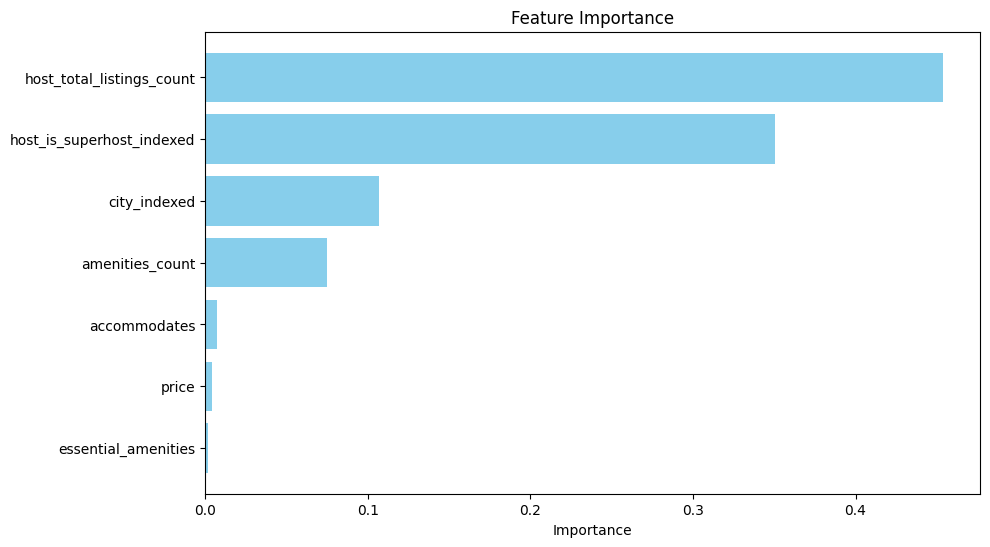

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'sorted_importance' is a list of tuples where each tuple is (feature_name, importance)
# Example: [('feature1', 0.2), ('feature2', 0.15), ...]

# Convert list to DataFrame for easier plotting
df_importance = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])

# Sort the DataFrame by importance
df_importance.sort_values(by='Importance', ascending=True, inplace=True)

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size as needed
plt.barh(df_importance['Feature'], df_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


## Create Model with Top 10 Features

In [0]:
# Selecting top important features
top_features = [feature for feature, importance in sorted_importance[:10]]
# Assuming 'data_with_review' is your DataFrame and has all the necessary columns

#Create a StringIndexer for the target column and naming it as target_label after converting it to numeric
labelIndexer = StringIndexer(inputCol='target', outputCol='target_label').setHandleInvalid("skip")


# Indexers for categorical features included in important features list
indexers = [
    StringIndexer(inputCol='host_is_superhost', outputCol='host_is_superhost_indexed').setHandleInvalid("skip"),
    StringIndexer(inputCol='city', outputCol='city_indexed').setHandleInvalid("skip")
]

# Assembler for combining feature columns
assembler = VectorAssembler(inputCols=top_features, outputCol="features")

# Label indexer for the target column
label_indexer = StringIndexer(inputCol="target", outputCol="target_label").setHandleInvalid("skip")

# Decision Tree Classifier
dtc = DecisionTreeClassifier(labelCol="target_label", featuresCol="features")

# Building the pipeline with all necessary components
pipeline = Pipeline(stages=indexers + [label_indexer, assembler, dtc])

# Fit the pipeline on the training data
model = pipeline.fit(data_with_review)

# Make predictions and evaluate the model
predictions = model.transform(data_with_review)
evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Model accuracy: ", accuracy)



Model accuracy:  0.5806312719191639


## Hyperparameter

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit

# Initialize the DecisionTreeClassifier
dtc = DecisionTreeClassifier(labelCol='target_label', featuresCol='features', maxBins=2432)


# Create the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(dtc.maxDepth, [5, 10, 20]) \
    .addGrid(dtc.maxBins, [1024, 2048, 2432]) \
    .addGrid(dtc.minInstancesPerNode, [1, 2, 4]) \
    .build()

# Create the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction", metricName="accuracy")

#Create the CrossValidator
cv = CrossValidator(estimator=dtc,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,
                    parallelism=4)  # Use 3+ folds in practice

# cv = TrainValidationSplit(estimator=dtc,
#                     estimatorParamMaps=paramGrid,
#                     evaluator=evaluator,
#                     trainRatio=0.8,
#                     parallelism=4)  

# Run cross-validation, and choose the best set of parameters.
cvModel2 = cv.fit(train_data)

# Make predictions on test data. cvModel uses the best model found.
prediction = cvModel2.transform(test_data)

# Evaluate the best model's performance
#f1_score = evaluator.evaluate(prediction)
acc = acc_evaluator.evaluate(prediction)
print("Test set Accuracy = " + str(acc))

# Print best model's parameters
bestModel = cvModel.bestModel
print(f"Best Param (maxDepth): {bestModel.getMaxDepth()}")
print(f"Best Param (maxBins): {bestModel.getMaxBins()}")
print(f"Best Param (minInstancesPerNode): {bestModel.getMinInstancesPerNode()}")

Test set Accuracy = 0.5846364437845112
Best Param (maxDepth): 10
Best Param (maxBins): 1024
Best Param (minInstancesPerNode): 4


In [0]:
# Get the best model from CrossValidator
bestModel = cvModel2.bestModel

# Print the parameters of the best model
print("Best model's parameters:")
print(f" - maxDepth: {bestModel._java_obj.getMaxDepth()}")
print(f" - maxBins: {bestModel._java_obj.getMaxBins()}")
print(f" - minInstancesPerNode: {bestModel._java_obj.getMinInstancesPerNode()}")

Best model's parameters:
 - maxDepth: 10
 - maxBins: 1024
 - minInstancesPerNode: 4


In [0]:
# Use the best model found by CrossValidator to make predictions on the test data
predictions = cvModel2.transform(test_data)

# Evaluate the model's accuracy on the test data
evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction", metricName="accuracy")

# Compute the accuracy on the test data
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

# Generate confusion matrix
confusion_matrix = predictions.groupBy('target_label').pivot('prediction', [0, 1, 2, 3]).count().na.fill(0).orderBy('target_label')
confusion_matrix.show()

Test Accuracy: 0.5846364437845112
+------------+-----+-----+---+---+
|target_label|    0|    1|  2|  3|
+------------+-----+-----+---+---+
|         0.0|13673| 7368|136|  0|
|         1.0| 7414|11358| 83|  0|
|         2.0| 1129| 1773|168|  0|
+------------+-----+-----+---+---+



## Applying Model on 0 Review Listings with Best Performing Model

In [0]:
# Applying the trained Random Forest model to the prediction dataset - the hold out zero reviews data
zeroReviewPredictions = cvModel2.transform(dataWithZeroReviewTransformed)

In [0]:
# Displaying predictions, probabilities, and features
zeroReviewPredictions.select("features", "rawPrediction", "probability", "prediction").show(truncate=False, n=5)

+----------------------------------------------------------+----------------------+-------------------------------------------------------------+----------+
|features                                                  |rawPrediction         |probability                                                  |prediction|
+----------------------------------------------------------+----------------------+-------------------------------------------------------------+----------+
|[0.0,1.0,0.0,0.0,7.0,3.0,2.0,1.0,1.0,1.0,222.0,10.0,3.0]  |[390.0,297.0,121.0]   |[0.48267326732673266,0.36757425742574257,0.14975247524752475]|0.0       |
|[0.0,1.0,2.0,0.0,1.0,112.0,2.0,2.0,2.0,4.0,500.0,29.0,3.0]|[3438.0,9315.0,1827.0]|[0.23580246913580247,0.6388888888888888,0.12530864197530864] |1.0       |
|[0.0,1.0,0.0,0.0,4.0,6.0,16.0,4.0,6.0,12.0,868.0,68.0,5.0]|[8.0,1.0,0.0]         |[0.8888888888888888,0.1111111111111111,0.0]                  |0.0       |
|[0.0,1.0,2.0,0.0,1.0,3.0,2.0,1.0,1.0,2.0,47.0,14.0,3.0]  

In [0]:
spark.stop()